In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [3]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

true_df["label"] = 1
fake_df["label"] = 0

df = pd.concat([true_df, fake_df])[["text", "label"]].dropna()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

def tokenize(text):
    return text.lower().split()

counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))

vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(20000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

class NewsDataset(Dataset):
    def __init__(self, texts, labels, max_len=512):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = encode(self.texts[idx])
        if len(enc) > self.max_len:
            enc = enc[:self.max_len]
        else:
            enc += [vocab["<PAD>"]] * (self.max_len - len(enc))

        return torch.tensor(enc, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = NewsDataset(train_texts, train_labels)
val_dataset = NewsDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)





c:\Users\ssk22\OneDrive\Documents\Fake_news_detect\proj\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/5: 100%|██████████| 1123/1123 [25:32<00:00,  1.36s/it, loss=0.000828]


Epoch 1 average loss: 0.0454


Epoch 2/5: 100%|██████████| 1123/1123 [30:02<00:00,  1.61s/it, loss=0.00186] 


Epoch 2 average loss: 0.0048


Epoch 3/5: 100%|██████████| 1123/1123 [28:58<00:00,  1.55s/it, loss=0.000127]


Epoch 3 average loss: 0.0038


Epoch 4/5: 100%|██████████| 1123/1123 [32:53<00:00,  1.76s/it, loss=4.73e-5] 


Epoch 4 average loss: 0.0027


Epoch 5/5: 100%|██████████| 1123/1123 [36:15<00:00,  1.94s/it, loss=0.000529]


Epoch 5 average loss: 0.0028


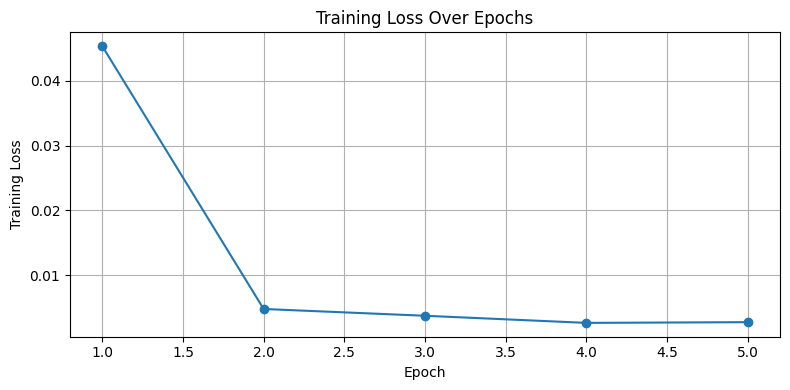

In [4]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, hidden_dim=256, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids):
        x = self.embedding(input_ids)              
        x = x.permute(1, 0, 2)                             
        x = self.transformer_encoder(x)                  
        x = x.mean(dim=0)                              
        x = self.fc(x)                                   
        return self.sigmoid(x).squeeze(1)                  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(vocab_size=len(vocab)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in progress:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        all_preds.extend(outputs)
        all_labels.extend(labels.numpy())

binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

Accuracy: 0.9991
Precision: 0.9991
AUC: 0.9997
EER: 0.0009


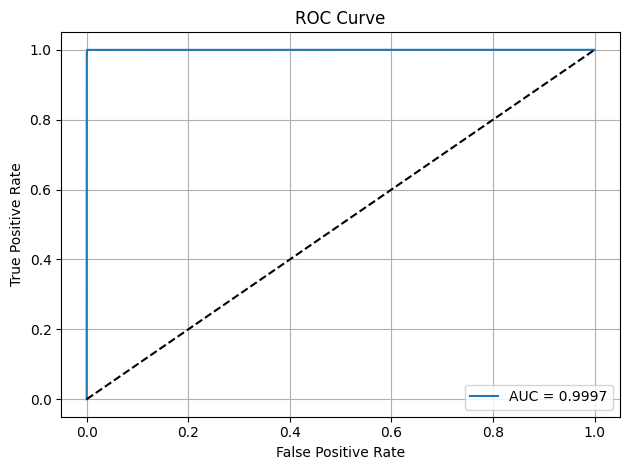

In [5]:
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")
print(f"EER: {eer:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy     : 0.9991
Precision    : 0.9991
Recall       : 0.9991
F1 Score     : 0.9991
AUC          : 0.9997
EER          : 0.0009
Log Loss     : 0.0050
MSE          : 0.0008
RMSE         : 0.0281
MAE          : 0.0013
Brier Score  : 0.0008


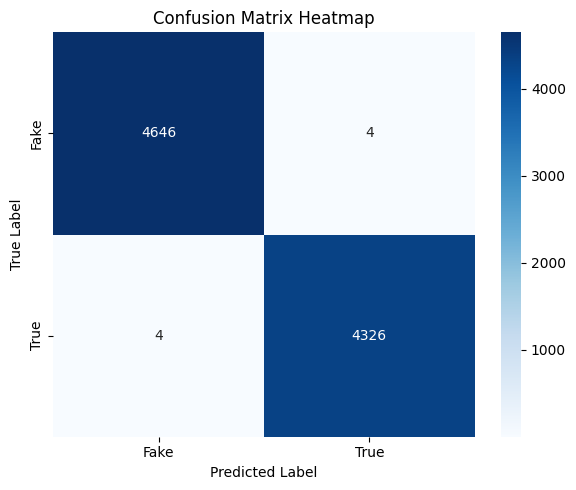

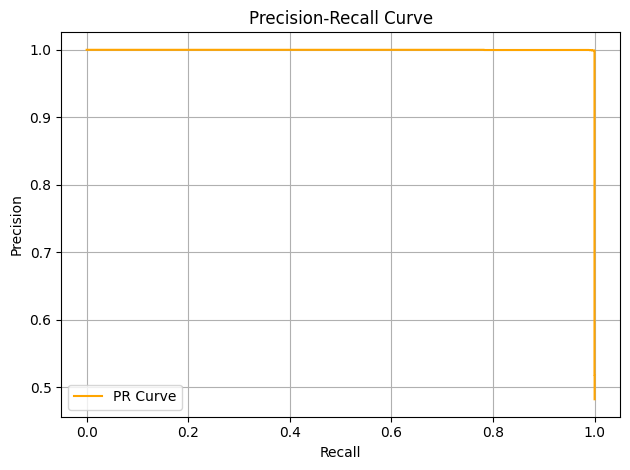

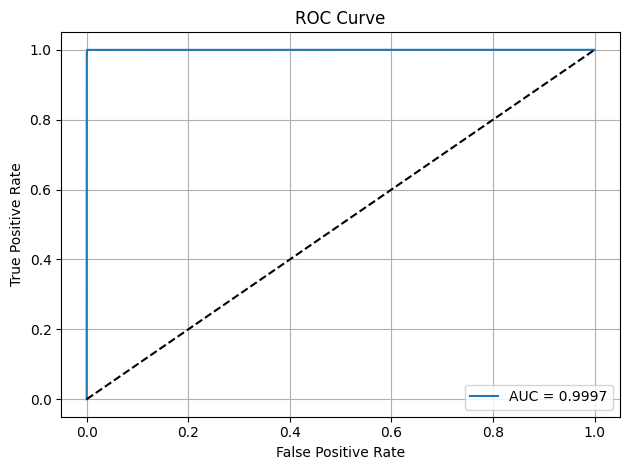

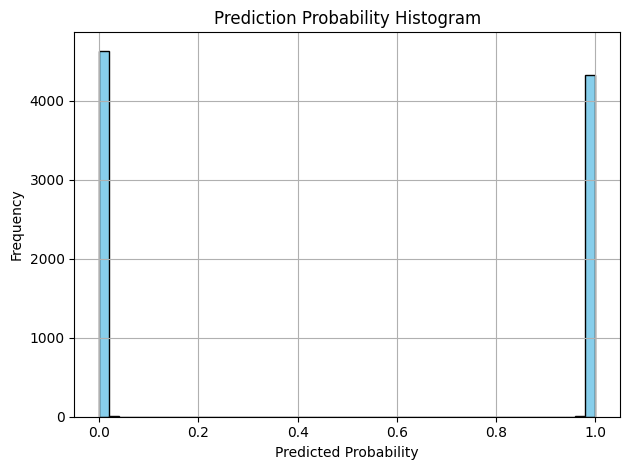

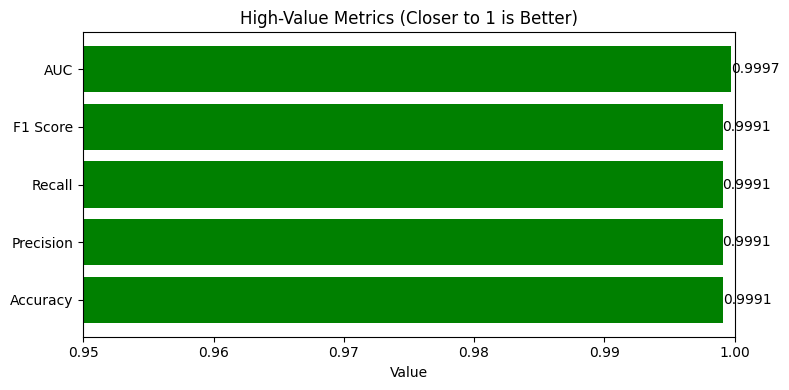

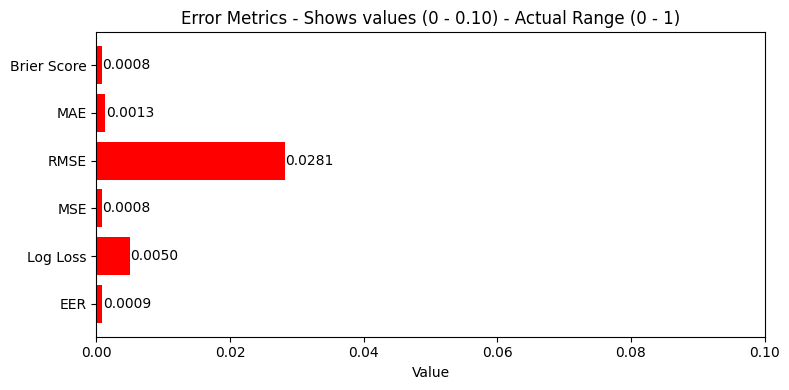

In [19]:
from sklearn.metrics import ( confusion_matrix, precision_recall_curve, f1_score, recall_score, log_loss, mean_squared_error, mean_absolute_error, brier_score_loss)
import seaborn as sns

recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
logloss = log_loss(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_preds)
brier = brier_score_loss(all_labels, all_preds)

print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"EER          : {eer:.4f}")
print(f"Log Loss     : {logloss:.4f}")
print(f"MSE          : {mse:.4f}")
print(f"RMSE         : {rmse:.4f}")
print(f"MAE          : {mae:.4f}")
print(f"Brier Score  : {brier:.4f}")

cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_preds)
plt.figure()
plt.plot(recall_vals, precision_vals, label="PR Curve", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(all_preds, bins=50, range=(0, 1), color='skyblue', edgecolor='black')
plt.title("Prediction Probability Histogram")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "AUC": auc,
    "EER": eer,
    "Log Loss": logloss,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "Brier Score": brier
}

high_metrics = {k: v for k, v in metrics.items() if v > 0.9}
error_metrics = {k: v for k, v in metrics.items() if v <= 0.1}

plt.figure(figsize=(8, 4))
plt.barh(list(high_metrics.keys()), list(high_metrics.values()), color='green')
plt.xlabel("Value")
plt.title("High-Value Metrics (Closer to 1 is Better)")
plt.xlim(0.95, 1)
for i, (k, v) in enumerate(high_metrics.items()):
    plt.text(v, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(list(error_metrics.keys()), list(error_metrics.values()), color='red')
plt.xlabel("Value")
plt.title("Error Metrics - Shows values (0 - 0.10) - Actual Range (0 - 1)")

plt.xlim(0, 0.1)

for i, (k, v) in enumerate(error_metrics.items()):
    plt.text(v + 0.0001, i, f"{v:.4f}", va='center') 

plt.tight_layout()
plt.show()

